# EVIC2019 - Tutorial de Dynamic Topic Models en el contexto del estallido social en Chile

# 1. Definición del Dataset y de sus _Slices_

In [2]:
import pandas as pd
from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

La carpeta _datasets_ del repositorio contiene una serie de archivos csv que se puede utilizar para experimentar el método Dynamic Topic Models en el contexto del estallido social chileno:
- ".. .csv": contiene ...

In [3]:
dataset="datasets/tweets.csv"
df = pd.read_csv(dataset)

Para definir cómo dividir el dataset en distintos periodos de tiempo, miremos primero cuántos documentos tenemos y cómo se distribuyen en el tiempo:

In [20]:
print("Number of documents: "+str(df.count()[0]))

#Modificar la columna "Time" para que sea reconocida como fecha y no como texto.
df['Time'] =  pd.to_datetime(df['Time']).dt.date

#Contar el número de documentos por fecha
query="""SELECT Time as Date,count(*) as Documents
FROM df GROUP BY Time;"""
result=sqldf(query)
result

Number of documents: 5173


,Date,Documents
0,2019-10-18,129
1,2019-10-19,289
2,2019-10-20,167
3,2019-10-21,311
4,2019-10-22,413
5,2019-10-23,283
6,2019-10-24,246
7,2019-10-25,166
8,2019-10-26,247
9,2019-10-27,154


En este ejemplo, divideremos los datos en cuatro segmentos de una semana:

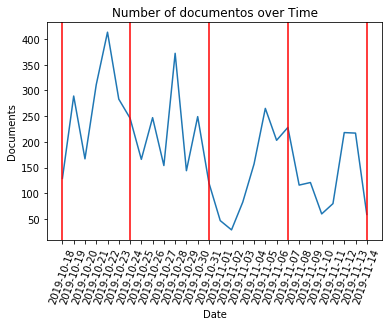

In [29]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
 
time_plot = sns.lineplot(x='Date',
                         y='Documents',
                         data=result
                         ).set_title('Number of documentos over Time')
plt.xticks(rotation=70)

plt.axvline(x='2019-10-18',color='red')
plt.axvline(x='2019-10-24',color='red')
plt.axvline(x='2019-10-31',color='red')
plt.axvline(x='2019-11-07',color='red')
plt.axvline(x='2019-11-14',color='red')

plt.show()

In [30]:
q="""SELECT 'Week 1',count(*) as 'Number of documents'
FROM df WHERE Time BETWEEN "2019-10-18" AND "2019-10-24"
UNION
SELECT 'Week 2',count(*) as 'Number of documents'
FROM df WHERE Time BETWEEN "2019-10-25" AND "2019-10-31"
UNION
SELECT 'Week 3',count(*) as 'Number of documents'
FROM df WHERE Time BETWEEN "2019-11-01" AND "2019-11-07"
UNION
SELECT 'Week 4',count(*) as 'Number of documents'
FROM df WHERE Time BETWEEN "2019-11-08" AND "2019-11-14"
;"""
result=sqldf(q)
result

,'Week 1',Number of documents
0,Week 1,1838
1,Week 2,1452
2,Week 3,1012
3,Week 4,871


Para identificar los _slices_, conservamos el número de documentos por cada segmento:

In [31]:
index_slices=[1838,1452,1012,871]

# 2. Preprocesamiento y representación vectorial de los textos

In [32]:
import spacy
nlp = spacy.load('es_core_news_md', disable=['parser','ner','textcat','...'] )

In [35]:
def preprocess(dataFrame,columnName):
    
    for index,rows in dataFrame.iterrows():
        
        text=rows[columnName]
        
        filteredText=""
        
        tokens = nlp(text)
        
        for token in tokens:
            if token.pos_ == "NOUN" :
                filteredText=filteredText+" "+str(token.text.lower().strip())
                
        dataFrame.loc[index,'filteredText']=filteredText

In [36]:
%%time
preprocess(df,"tweet_text")


CPU times: user 1min 57s, sys: 53.8 ms, total: 1min 57s
Wall time: 29.5 s


In [37]:
df

,Time,screen_name,tweet_text,URL1,filteredText
0,2019-10-24,ElDeportivoLT,🔴 Jorge Valdivia se defiende de emplazamientos...,https://t.co/NglhmLjsfe,emplazamientos apoyo
1,2019-10-24,El_Ciudadano,RT @yisejac: #Chile el Oasis de Piñera Pinoche...,https://t.co/78JGGmSJyP,
2,2019-10-24,Cooperativa,Alcaldesa Evelyn Matthei dispuesta a ingresar ...,https://t.co/kZztdK0vpu,gabinete
3,2019-10-24,agenciaunochile,Gobierno envió proyecto que deja sin efecto al...,https://t.co/ntJmq0WW8Y,proyecto efecto alza energía
4,2019-10-24,PublimetroChile,El Presidente va a llamar a la Alta Comisionad...,https://t.co/LLgO3svULZ,
5,2019-10-24,LID_Chile,Las migajas de #Piñera y las trampas del régim...,https://t.co/KJmJlbGd9x #ChileQuiereCambiosً,migajas trampas régimen
6,2019-10-24,cambio21cl,"Carlos Caszely y su verdad: ""A Piñera solo le ...",https://t.co/e6LXCpES5V,verdad nariz payaso m
7,2019-10-24,ElDeportivoLT,"🏅🇨🇱 El llamado de Bárbara Riveros a Piñera: ""C...",https://t.co/6kdWNODwgF,triatleta deportistas
8,2019-10-24,LaRedTV,Heraldo Muñoz analiza nuevas medidas anunciada...,https://t.co/UjyN3gpsQD #EstadosDeEmergenciaMV,medidas presidente
9,2019-10-24,msncl,El fuerte pedido de Arturo Vidal a Piñera,https://t.co/95272Nuvy4,pedido


In [ ]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

documents=list(df['filteredText'])
documents=[x.split(" ") for x in documents]


dictionary = Dictionary(documents)

dictionary.filter_extremes(no_below=0.1,no_above=0.8)

corpus = [dictionary.doc2bow(doc) for doc in documents] 

model = TfidfModel(corpus)

vectorizedCorpus = model[corpus]

## 3. Optimización de modelos de tópicos dinámicos

In [ ]:
DTM_models=[]

In [ ]:
%%time
from IPython.display import Audio
import numpy as np

from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel

import time

init=time.time()

s=time.time()

ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=index_slices, 
                                 num_topics=3,
                                 chain_variance=0.9,
                                 alphas=0.3,
                                 passes=100,
                                 chunksize=24000,
                                 em_min_iter=6,
                                 em_max_iter=30)

DTM_models.append(ldaseq)

e=time.time()
print("Time needed for model optimization:",(e-s))

end=time.time()
print(end-init)

In [ ]:
ldaseq.print_topics(time=2)

In [ ]:
from gensim.test.utils import common_corpus
from gensim.models import LdaSeqModel
from gensim.test.utils import datapath
path_of_model = datapath("pinera_3_topics_0.9_alpha_0.9_chain")
print(path_of_model)
ldaseq.save(path_of_model)

## 4. Visualización de los resultados